# Dataset 1 - Regression

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE Logit Loss to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is linear. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [4]:
X,Y = regressionDataset.regression_data(n_samples,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0 -1.255677 -0.230819  0.833125  1.243433  1.273007 -0.622568 -0.368909   
1  0.784889 -0.238285 -0.023092 -0.325298 -0.863499 -0.272078 -0.809254   
2  1.247612 -1.014149  1.470985 -1.445428 -0.519451 -0.576741 -0.086047   
3 -1.131941  1.074257  0.501755 -0.078943  0.978978  1.814076  1.309787   
4  0.204617 -0.731034 -0.494850  2.148085 -0.732008 -0.477900  1.257488   

         X8        X9       X10           Y  
0 -0.042506  0.308564  0.006666  -48.519498  
1 -0.391275 -0.076270 -1.391358 -187.901610  
2  1.086550 -0.705045 -2.665203  -95.527727  
3  0.278289  0.395952  0.712825  179.104910  
4 -0.020059 -0.658875  1.122324  148.042753  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.915e+07
Date:                Sun, 17 Oct 2021   Prob (F-statistic):          4.79e-291
Time:                        12:04:48   Log-Likelihood:                 622.95
No. Observations:                 100   AIC:                            -1224.
Df Residuals:                      89   BIC:                            -1195.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.469e-17   5.05e-05   6.86e-13      1.0

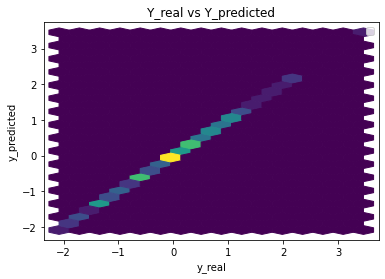

Performance Metrics
Mean Squared Error: 2.273482831771937e-07
Mean Absolute Error: 0.00038274533629185275
Manhattan distance: 0.03827453362918527
Euclidean distance: 0.004768105317389641


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [6]:
n_epochs = 5000
error = 0.1
batch_size = n_samples//2

## GAN Model

In [7]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [9]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


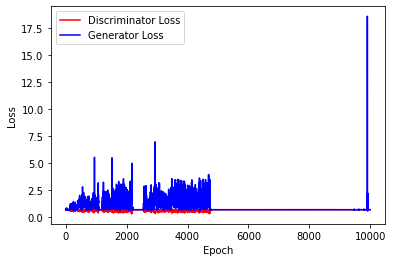

In [10]:
train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

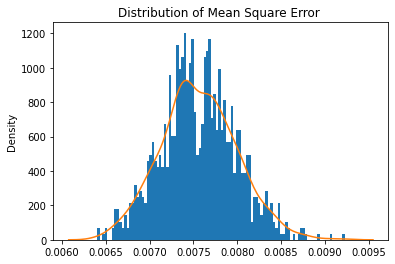

Mean Square Error: 0.007563650341830856


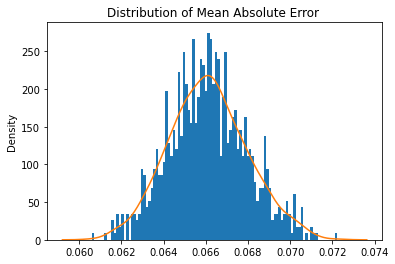

Mean Absolute Error: 0.06610748230827972


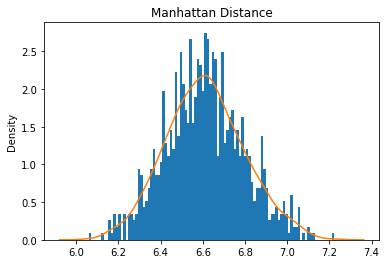

Mean Manhattan Distance: 6.610748230827972


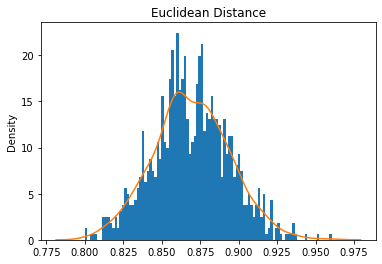

Mean Euclidean Distance: 0.8693400105731734


In [11]:
train_test.test_generator(generator,real_dataset,device)

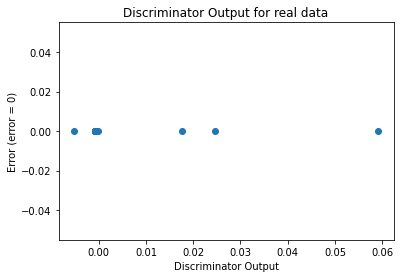

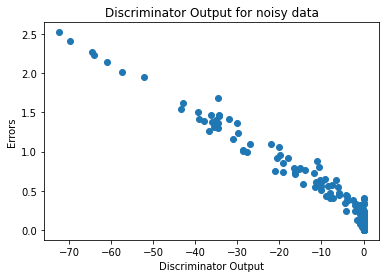

In [19]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

# ABC GAN Model

#### Training the network

In [13]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCEWithLogitsLoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

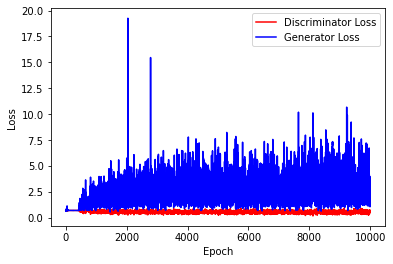

In [15]:
ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

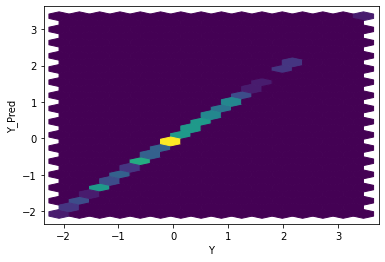

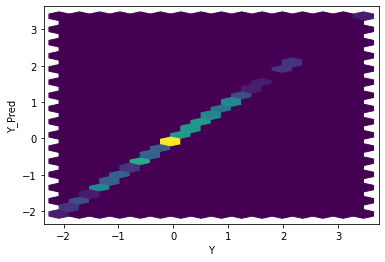

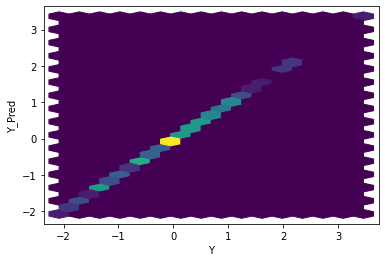

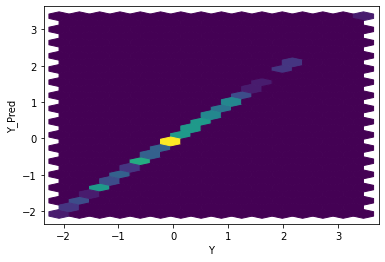

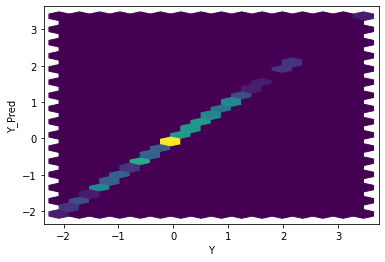

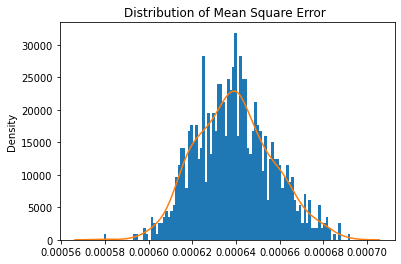

Mean Square Error: 0.0006392158099373061


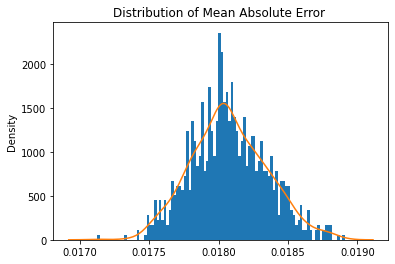

Mean Absolute Error: 0.018074657459668814
Mean Manhattan Distance: 1.8074657459668815


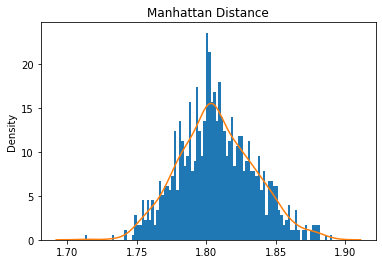

Mean Euclidean Distance: 0.2528034315210886


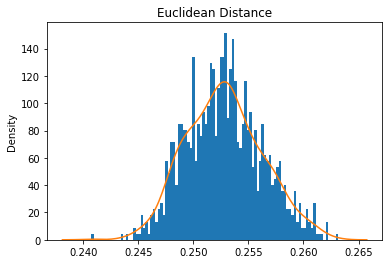

In [16]:
ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

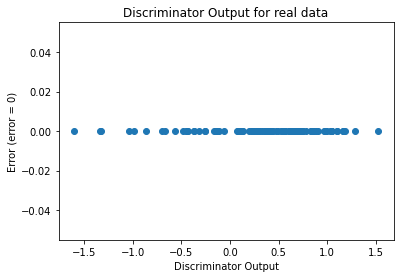

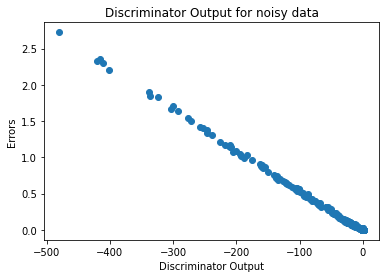

In [17]:
sanityChecks.discProbVsError(real_dataset,disc,device)